In [67]:
import os
from collections import defaultdict
from itertools import combinations
import pandas as pd
import pickle
import numpy as np
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.spike_recording as recording
import behavior.boris_extraction as boris
from trodes import read_exported as tr
import spike.spike_analysis.pca_trajectories as pca_trajectories
import pickle
import behavior.behavioral_epoch_tools as bet
import matplotlib.pyplot as plt
from pathlib import Path
import h5py

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

In [68]:
only_subject_collection = collection.SpikeCollection.load_collection(r'C:\Users\zhaoz\Desktop\Research\SocialMemory\only_subject\only_subjects_spike_collection\spike_collection.json')
timestamps_dir = (r"C:\Users\zhaoz\Desktop\Research\SocialMemory\only_subject\videoTimeStamps")
timestamps_dict = {}
for root, dirs, files in os.walk(timestamps_dir):
    for file in files:
        if file.endswith('.videoTimeStamps'):
            file_path = os.path.join(root, file)
            timestamp_array = tr.readCameraModuleTimeStamps(file_path)
            rec_name = file.replace('.videoTimeStamps','')
            timestamps_dict[rec_name] = timestamp_array

print(timestamps_dict.keys())


dict_keys(['11_12_23_24.1', '11_12_23_24.2', '11_13_21_22.1', '11_13_21_22.2', '21_22_41_44.1', '21_22_41_44.2', '23_24_31_32.1', '23_24_31_32.2'])


In [69]:
# data_path = r"C:\Users\megha\UFL Dropbox\Meghan Cum\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\Only_Subjects (phase 5)\data"

# def find_start_recording_time(data_path):
#     first_timestamp_dict = {}
#     """If the timestamps file is found at self.merged_rec_path, then use it. Otherwise ask user to create it"""
#     for rec_dir in os.listdir(data_path):
#         if rec_dir.endswith('.rec'):
#             rec_path = os.path.join(data_path, rec_dir)
#             first_timestamp_dict[rec_dir] = {}
#             for subj_dir in os.listdir(rec_path):
#                 if subj_dir.endswith('_merged.time'):
#                     time_path = os.path.join(rec_path, subj_dir)
#                     for file in os.listdir(time_path):
#                         if file.endswith('.timestamps.dat'):
#                             timestamps_file_path = os.path.join(time_path, file)
#                             timestamps = tr.read_trodes_extracted_data_file(timestamps_file_path)
#                             first_timestamp = int(timestamps["first_timestamp"])
#                             first_timestamp_dict[rec_dir][subj_dir] = first_timestamp
#     return first_timestamp_dict

first_timestamps = {'11_12_23_24.rec': {'11_CNF_merged.time': 1571577, '12_CNF_merged.time': 1571577, '23_CNF_merged.time': 1571577, '24_CNF_merged.time': 1571577}, '11_13_21_22.rec': {'11_NCF_merged.time': 3545055, '13_NCF_merged.time': 3545055, '21_NCF_merged.time': 3545055, '22_NCF_merged.time': 3545055}, '21_22_41_44.rec': {'21_FCN_merged.time': 5303723, '22_FCN_merged.time': 5303723, '41_FCN_merged.time': 5303723, '44_FCN_merged.time': 5303723}, '23_24_31_32.rec': {'23_NFC_merged.time': 2728778, '24_NFC_merged.time': 2728778, '31_NFC_merged.time': 2728778, '32_NFC_merged.time': 2728778}}
print(first_timestamps)


{'11_12_23_24.rec': {'11_CNF_merged.time': 1571577, '12_CNF_merged.time': 1571577, '23_CNF_merged.time': 1571577, '24_CNF_merged.time': 1571577}, '11_13_21_22.rec': {'11_NCF_merged.time': 3545055, '13_NCF_merged.time': 3545055, '21_NCF_merged.time': 3545055, '22_NCF_merged.time': 3545055}, '21_22_41_44.rec': {'21_FCN_merged.time': 5303723, '22_FCN_merged.time': 5303723, '41_FCN_merged.time': 5303723, '44_FCN_merged.time': 5303723}, '23_24_31_32.rec': {'23_NFC_merged.time': 2728778, '24_NFC_merged.time': 2728778, '31_NFC_merged.time': 2728778, '32_NFC_merged.time': 2728778}}


In [70]:
only_subject_collection.recording_details()

Recording Details:

Recording: 11_CNF_merged.rec
  Subject: 1.1
  Number of Good Units: 20
  Recording Length: 40.04 minutes
  Events per Event Type: {'baseline': 15, 'cagemate': 48, 'exposure 1': 48, 'exposure 2': 38, 'exposure 3': 39, 'familiar': 39, 'novel': 38}

Recording: 11_NCF_merged.rec
  Subject: 1.1
  Number of Good Units: 13
  Recording Length: 41.71 minutes
  Events per Event Type: {'baseline': 15, 'cagemate': 13, 'exposure 1': 25, 'exposure 2': 13, 'exposure 3': 32, 'familiar': 32, 'novel': 25}

Recording: 12_CNF_merged.rec
  Subject: 1.2
  Number of Good Units: 16
  Recording Length: 40.04 minutes
  Events per Event Type: {'baseline': 15, 'cagemate': 41, 'exposure 1': 41, 'exposure 2': 23, 'exposure 3': 20, 'familiar': 20, 'novel': 23}

Recording: 13_NCF_merged.rec
  Subject: 1.3
  Number of Good Units: 19
  Recording Length: 41.71 minutes
  Events per Event Type: {'baseline': 15, 'cagemate': 18, 'exposure 1': 29, 'exposure 2': 18, 'exposure 3': 9, 'familiar': 9, 'novel':

In [71]:
for recording in only_subject_collection.recordings:
    subject = str(int(recording.name.split('_')[0])/10)
    recording.set_subject(subject)

In [72]:
boris_path = r"C:\Users\zhaoz\Desktop\Research\SocialMemory\only_subject\only_subjects"

boris_dfs = {}

for file in os.listdir(boris_path):
    csv_path = os.path.join(boris_path, file)
    df = pd.read_csv(csv_path)
    boris_dfs[file] = df

In [73]:
for roots, dirs, filenames in os.walk(boris_path):    
    groups = defaultdict(list)
    for filename in filenames:
        prefix = filename.rsplit('.', 1)[0].split('.')[0]  # Split from right, take first part
        groups[prefix].append(filename)

    # Convert to list of tuples
    pairs = [tuple(group) for group in groups.values()]
print(pairs)

[('11_12_23_24.1.csv', '11_12_23_24.2.csv'), ('11_13_21_22.1.csv', '11_13_21_22.2.csv'), ('21_22_41_44.1.csv', '21_22_41_44.2.csv'), ('23_24_31_32.1.csv', '23_24_31_32.2.csv')]


In [74]:
def get_behavior_bouts_frame(boris_df, cameratimestamps, first_timestamp, subject, behavior, min_iti=0, min_bout=0):
    """
    extracts behavior bout start and stop times from a boris df from a NONE-MAC scored video and thresholds behavior bouts
    individually by subject and behavior returns start_stop_array ordered by start values. takes in a cameratimestamps array
    and first_timestamp to adjust for the start of the recording (cameratimestamps second 0 starts at stream) so adjusts start and stop 
    values using first_timstamp so the 0th second aligns to play. 

    Args (6 total, 4 required):
        boris_df: pandas dataframe of a boris file (aggregated event table)
        cameratimestamps: numpy array of camera timestamps (in seconds) read from .videoTimeStamps file generated from trodes
        first_timestamp: int, first timestamp of the recording in timestamps from trodes
        subject: list of strings or ints, desired subject(s)
                as written in boris_df, i.e. 'novel' or 1.1
        behavior: list of strings, desired behavior(s) (as written in boris_df)
        min_iti: float, default=0, bouts w/ itis(s) < min_iti will be combined
        min_bout: float, default=0, bouts < min_bout(s) will be deleted

    Returns (1):
        numpy array (ndim=(n bouts, 2)) of start&stop times (ms)
    """
    start_stop_arrays = []
    for mouse in subject:
        subject_df = boris_df[boris_df["Subject"] == mouse]
        subject_df["Image index stop"] = subject_df["Image index stop"].fillna(
            subject_df["Image index start"].shift(-1)
        )
        behavior_arrays = []
        for act in behavior:
            behavior_df = subject_df[subject_df["Behavior"] == act]
            start_stop_array = behavior_df[["Image index start", "Image index stop"]].to_numpy()
            behavior_arrays.append(start_stop_array)
        start_stop_array = np.concatenate(behavior_arrays)
        start_stop_array = start_stop_array.astype(int)
        start_stop_array_s = cameratimestamps[start_stop_array]
        start_stop_arrays.append(bet.threshold_bouts(start_stop_array_s, min_iti, min_bout))
    start_stop_array = np.concatenate(start_stop_arrays)
    organizer = np.argsort(start_stop_array[:, 0])
    start_stop_array_stream_indexed = start_stop_array[organizer]
    start_stop_array_play_indexed = start_stop_array_stream_indexed - (first_timestamp /20000) # adjust for first timestamp
    start_stop_array_ms = start_stop_array_play_indexed * 1000 # convert to ms

    return start_stop_array_ms

def get_behavior_bouts_fps(boris_df, cameratimestamps, first_timestamp, subject, behavior, min_iti=0, min_bout=0):
    """
    extracts behavior bout start and stop times from a boris df
    thresholds individually by subject and behavior
    returns start_stop_array ordered by start values

    Args (6 total, 4 required):
        boris_df: pandas dataframe of a boris file (aggregated event table)
        cameratimestamps: numpy array of camera timestamps (in seconds) read from .videoTimeStamps file generated from trodes
        subject: list of strings or ints, desired subject(s)
                as written in boris_df, i.e. 'novel' or 1.1
        behavior: list of strings, desired behavior(s) (as written in boris_df)
        min_iti: float, default=0, bouts w/ itis(s) < min_iti will be combined
        min_bout: float, default=0, bouts < min_bout(s) will be deleted

    Returns (1):
        numpy array (ndim=(n bouts, 2)) of start&stop times (ms)
    """
    start_stop_arrays = []
    for mouse in subject:
        subject_df = boris_df[boris_df["Subject"] == mouse]
        if not subject_df.empty:
            behavior_arrays = []
            column_names = subject_df.columns
            for column_name in column_names:
                if 'FPS' in column_name:
                    fps_column = column_name
                    break
            try:
                fps = int(subject_df[fps_column].unique()[0])
            except IndexError:
                print(subject_df)
            for act in behavior:
                behavior_df = subject_df[subject_df["Behavior"] == act]
                start_stop_array = behavior_df[["Start (s)", "Stop (s)"]].to_numpy()
                behavior_arrays.append(start_stop_array)
            start_stop_array = np.concatenate(behavior_arrays)
            start_stop_array = np.round(start_stop_array).astype(int) *fps
            start_stop_array_s = cameratimestamps[start_stop_array]
            start_stop_arrays.append(bet.threshold_bouts(start_stop_array_s, min_iti, min_bout))
        else:
            start_stop_array = np.array([])
            start_stop_arrays.append(start_stop_array)
    if start_stop_arrays:
        # Filter out any empty arrays (extra safety)
        valid_arrays = [arr for arr in start_stop_arrays if arr.size > 0]
        
        if valid_arrays:
            start_stop_array = np.concatenate(valid_arrays)
            organizer = np.argsort(start_stop_array[:, 0])
            start_stop_array_stream_indexed = start_stop_array[organizer]
            start_stop_array_play_indexed = start_stop_array_stream_indexed - (first_timestamp / 20000)  
# adjust for first timestamp
            start_stop_array_ms = start_stop_array_play_indexed * 1000  # convert to ms
            return start_stop_array_ms
    
    # Return empty array with correct shape if no data found
    return np.empty((0, 2))

In [75]:
def get_ins_outs(boris_df, fps, timestamps, first_timestamp, rec, ins, outs):       
    if len(boris_df[boris_df['Behavior'] == 'mice back in']["Start (s)"]) == 6:
        if 'Image index start' not in boris_df.columns:
            ins_times = np.array(boris_df[boris_df['Behavior'] == 'mice back in']["Start (s)"])[[0,2,4]]
            outs_times = np.array(boris_df[boris_df['Behavior'] == 'mice taken out']["Start (s)"])[[0,2]]
            ins_frames = np.round(ins_times * fps).astype(int)
            outs_frames = np.round(outs_times * fps).astype(int)
            
        else:
            ins_frames = np.array(boris_df[boris_df['Behavior'] == 'mice back in']["Image index start"])[[0,2,4]]
            outs_frames= np.array(boris_df[boris_df['Behavior'] == 'mice taken out']["Image index start"])[[0,2]]
    else:
        if 'Image index start' not in boris_df.columns:
            ins_times = np.array(boris_df[boris_df['Behavior'] == 'mice back in']["Start (s)"])
            outs_times = np.array(boris_df[boris_df['Behavior'] == 'mice taken out']["Start (s)"])
            ins_frames = np.round(ins_times * fps).astype(int)
            outs_frames = np.round(outs_times * fps).astype(int)
            
        else:
            ins_frames = np.array(boris_df[boris_df['Behavior'] == 'mice back in']["Image index start"])
            outs_frames = np.array(boris_df[boris_df['Behavior'] == 'mice taken out']["Image index start"])
    ins_times = timestamps[ins_frames.astype(int)] - (first_timestamp / 20000)  # adjust for first timestamp
    outs_times = timestamps[outs_frames.astype(int)] - (first_timestamp / 20000)  # adjust for first timestamp
    ins[rec] = ins_times * 1000
    outs[rec] = outs_times * 1000
    if len(ins_times) != 3:
        print(rec, 'in')
    if len(outs_times) != 2:
        print(rec, 'out')

    return ins, outs

In [76]:
from importlib import reload
from collections import defaultdict
reload(boris)

bouts = {}
ins = {}
outs = {}
bout_arrays = {}
for rec_pair in pairs:
    common = rec_pair[0].split('.')[0]
    rec_name = common + '.rec'
    first_timestamp = list(first_timestamps[rec_name].values())[0]
    subjects = []
    for i in range(4):
        subjects.append(str(int(common.split('_')[i])/10))
    bouts[common] = {str(subject): None for subject in subjects}
    for rec in rec_pair:
        timestamps = timestamps_dict[rec.replace('.csv', '')]
        example_df = boris_dfs[rec]
        example_df['Subject'] = example_df['Subject'].astype(str)
        column_names = example_df.columns
        for column_name in column_names:
            if 'FPS' in column_name:
                fps_column = column_name
                break
        fps = int(example_df[fps_column].unique()[0])
        ins, outs = get_ins_outs(example_df, fps, timestamps, first_timestamp, rec, ins, outs)
        for subject in subjects:
            if 'Image index start' not in example_df.columns:
                bout_array = get_behavior_bouts_fps(example_df, timestamps, first_timestamp, [subject], ['facial sniffing'], min_iti = 1, min_bout = 0.5)

            else:
                bout_array = get_behavior_bouts_frame(example_df, timestamps, first_timestamp, [subject], ['facial sniffing'], min_iti = 1, min_bout = 0.5)
                
            if bouts[common][str(subject)] is None:
                bouts[common][str(subject)] = bout_array

            else:
                all_bouts = np.concatenate([bouts[common][str(subject)], bout_array])
                sorted_bouts = all_bouts[np.argsort(all_bouts[:,0])]
                bouts[common][str(subject)] = sorted_bouts


C:\Users\zhaoz\AppData\Local\Temp\ipykernel_74008\2379275627.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df["Image index stop"] = subject_df["Image index stop"].fillna(
C:\Users\zhaoz\AppData\Local\Temp\ipykernel_74008\2379275627.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df["Image index stop"] = subject_df["Image index stop"].fillna(
C:\Users\zhaoz\AppData\Local\Temp\ipykernel_74008\2379275627.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [77]:
for rec in bouts.keys():
    for subject, sniffs in bouts[rec].items():
        if len(sniffs)== 0:
            print(rec, subject)


In [78]:
print(ins['11_12_23_24.2.csv']/60000)
print(outs['11_12_23_24.2.csv']/60000)
print(ins['11_12_23_24.1.csv']/60000)
print(outs['11_12_23_24.1.csv']/60000)

[10.05101667 20.2233     30.22003917]
[20.10203583 30.0756775 ]
[10.13994333 20.20135667 30.209645  ]
[20.10203583 30.08491667]


In [79]:
pickle_this(ins, r'pilot2/only_subjects/ins_dict.pkl')
pickle_this(outs, r'pilot2/only_subjects/outs_dict.pkl')

In [80]:

# 11_12_23_24.1 = 11_12, 11_24, 23_11
# 11_12_23_24.2 = 23_24, 12_23, 12_24
CNF = bouts['11_12_23_24']

baseline_array_11 = bet.random_event_generator(0, ins['11_12_23_24.1.csv'][0], len_event = 2500, no_events = 15)
baseline_array_12 = bet.random_event_generator(0, ins['11_12_23_24.1.csv'][0], len_event = 2500, no_events = 15)

baseline_array_23 = bet.random_event_generator(0, ins['11_12_23_24.2.csv'][0], len_event = 2500, no_events = 15)
baseline_array_24 = bet.random_event_generator(0, ins['11_12_23_24.2.csv'][0], len_event = 2500, no_events = 15)

cagemate_array_11 = CNF['1.1'][CNF['1.1'][:, 1] < outs['11_13_21_22.1.csv'][0]]
cagemate_array_12 = CNF['1.2'][CNF['1.2'][:, 1] < outs['11_13_21_22.1.csv'][0]]

cagemate_array_23 = CNF['2.3'][CNF['2.3'][:, 1] < outs['11_13_21_22.2.csv'][0]]
cagemate_array_24 = CNF['2.4'][CNF['2.4'][:, 1] < outs['11_13_21_22.2.csv'][0]]

novel_array_11 = CNF['1.1'][CNF['1.1'][:, 1] > ins['11_12_23_24.1.csv'][1]]
novel_array_11 = novel_array_11[novel_array_11[:,1] < outs['11_12_23_24.1.csv'][1]]

novel_array_24 = CNF['2.4'][CNF['2.4'][:, 1] > ins['11_12_23_24.1.csv'][1]]
novel_array_24 = novel_array_24[novel_array_24[:,1] < outs['11_12_23_24.1.csv'][1]]


novel_array_23 = CNF['2.3'][CNF['2.3'][:, 1] > ins['11_12_23_24.2.csv'][1]]
novel_array_23 = novel_array_23[novel_array_23[:,1] < outs['11_12_23_24.2.csv'][1]]

novel_array_12 = CNF['1.2'][CNF['1.2'][:, 1] > ins['11_12_23_24.2.csv'][1]]
novel_array_12 = novel_array_12[novel_array_12[:,1] < outs['11_12_23_24.2.csv'][1]]


familiar_array_11 = CNF['1.1'][CNF['1.1'][:, 1] > ins['11_12_23_24.1.csv'][2]]
familiar_array_23 = CNF['2.3'][CNF['2.3'][:, 1] > ins['11_12_23_24.1.csv'][2]]
familiar_array_12 = CNF['1.2'][CNF['1.2'][:, 1] > ins['11_12_23_24.2.csv'][2]]
familiar_array_24 = CNF['2.4'][CNF['2.4'][:, 1] > ins['11_12_23_24.2.csv'][2]]

behavior_dicts = {'23_CNF_merged.rec': {'cagemate': cagemate_array_23, 
                                       'familiar': familiar_array_23,
                                       'novel': novel_array_23,
                                       'baseline': baseline_array_23},
                 '11_CNF_merged.rec': {'cagemate': cagemate_array_11, 
                                       'familiar': familiar_array_11,
                                       'novel': novel_array_11,
                                       'baseline': baseline_array_11},
                 '12_CNF_merged.rec': {'cagemate': cagemate_array_12, 
                                       'familiar': familiar_array_12,
                                       'novel': novel_array_12,
                                       'baseline': baseline_array_12},
                 '24_CNF_merged.rec': {'cagemate': cagemate_array_24, 
                                       'familiar': familiar_array_24,
                                       'novel': novel_array_24,
                                       'baseline': baseline_array_24}}

In [81]:
print(ins['11_13_21_22.1.csv'])
print(outs['11_13_21_22.1.csv'])
print(ins['11_13_21_22.2.csv'])
print(outs['11_13_21_22.2.csv'])

[ 610683.3  1231137.1  1869607.25]
[1228573.25 1865934.7 ]
[ 602714.55 1235433.3  1874942.85]
[1222752.6  1859005.35]


In [82]:
#11_13_21_22.1 = 13_21, 11_13, 11_21
#11_13_21_22.2 = 11_22, 21_22, 13_22

NCF = bouts['11_13_21_22']

baseline_array_13 = bet.random_event_generator(0, ins['11_13_21_22.1.csv'][0], len_event = 2500, no_events = 15)
baseline_array_21 = bet.random_event_generator(0, ins['11_13_21_22.1.csv'][0], len_event = 2500, no_events = 15)

baseline_array_22 = bet.random_event_generator(0, ins['11_13_21_22.2.csv'][0], len_event = 2500, no_events = 15)
baseline_array_11 = bet.random_event_generator(0, ins['11_13_21_22.2.csv'][0], len_event = 2500, no_events = 15)

novel_array_21 = NCF['2.1'][NCF['2.1'][:, 1] < outs['11_13_21_22.1.csv'][0]]
novel_array_13 = NCF['1.3'][NCF['1.3'][:, 1] < outs['11_13_21_22.1.csv'][0]]


novel_array_11 = NCF['1.1'][NCF['1.1'][:, 1] < outs['11_13_21_22.2.csv'][0]]
novel_array_22 = NCF['2.2'][NCF['2.2'][:, 1] < outs['11_13_21_22.2.csv'][0]]

cagemate_array_11 = NCF['1.1'][NCF['1.1'][:, 1] > ins['11_13_21_22.1.csv'][1]]
cagemate_array_11 = cagemate_array_11[cagemate_array_11[:,1] < outs['11_13_21_22.1.csv'][1]]

cagemate_array_13 = NCF['1.3'][NCF['1.3'][:, 1] > ins['11_13_21_22.1.csv'][1]]
cagemate_array_13 = cagemate_array_13[cagemate_array_13[:,1] < outs['11_13_21_22.1.csv'][1]]

cagemate_array_21 = NCF['2.1'][NCF['2.1'][:, 1] > ins['11_13_21_22.2.csv'][1]]
cagemate_array_21 = cagemate_array_21[cagemate_array_21[:,1] < outs['11_13_21_22.2.csv'][1]]

cagemate_array_22 = NCF['2.2'][NCF['2.2'][:, 1] > ins['11_13_21_22.2.csv'][1]]
cagemate_array_22 = cagemate_array_22[cagemate_array_22[:,1] < outs['11_13_21_22.2.csv'][1]]

familiar_array_11 = NCF['1.1'][NCF['1.1'][:, 1] > ins['11_13_21_22.1.csv'][2]]
familiar_array_21 = NCF['2.1'][NCF['2.1'][:, 1] > ins['11_13_21_22.1.csv'][2]]
familiar_array_22 = NCF['2.2'][NCF['2.2'][:, 1] > ins['11_13_21_22.2.csv'][2]]
familiar_array_13 = NCF['1.3'][NCF['1.3'][:, 1] > ins['11_13_21_22.2.csv'][2]]


behavior_dicts.update({'22_NCF_merged.rec': {'cagemate': cagemate_array_22, 
                                       'familiar': familiar_array_22,
                                       'novel': novel_array_22,
                                       'baseline': baseline_array_22},
                 '11_NCF_merged.rec': {'cagemate': cagemate_array_11, 
                                       'familiar': familiar_array_11,
                                       'novel': novel_array_11,
                                       'baseline': baseline_array_11},
                 '13_NCF_merged.rec': {'cagemate': cagemate_array_13, 
                                       'familiar': familiar_array_13,
                                       'novel': novel_array_13,
                                       'baseline': baseline_array_13},
                 '21_NCF_merged.rec': {'cagemate': cagemate_array_21, 
                                       'familiar': familiar_array_21,
                                       'novel': novel_array_21,
                                       'baseline': baseline_array_21}})




In [83]:
print(ins['21_22_41_44.1.csv'])
print(outs['21_22_41_44.1.csv'])
print(ins['21_22_41_44.2.csv'])
print(outs['21_22_41_44.2.csv'])

[ 613593.65 1240491.75 1862747.2 ]
[1235502.65 1847017.6 ]
[ 605902.1  1243817.85 1858866.75]
[1229959.15 1853461.85]


In [84]:
#21_22_41_44.1 = 21_41, 21_22, 41_22 
#21_22_41_44.2 = 22_44, 41_44, 44_21   
#example of two arrays that go together to calculate reciprocal cagemate interactions
# array1 = behavior_dicts['22_FCN_merged.rec']['cagemate']
# array2 = behavior_dicts['21_FCN_merged.rec']['cagemate']

FCN = bouts['21_22_41_44']

baseline_array_21 = bet.random_event_generator(0, ins['21_22_41_44.1.csv'][0], len_event = 2500, no_events = 15)
baseline_array_41 = bet.random_event_generator(0, ins['21_22_41_44.1.csv'][0], len_event = 2500, no_events = 15)

baseline_array_22 = bet.random_event_generator(0, ins['21_22_41_44.2.csv'][0], len_event = 2500, no_events = 15)
baseline_array_44 = bet.random_event_generator(0, ins['21_22_41_44.2.csv'][0], len_event = 2500, no_events = 15)


familiar_array_21 = FCN['2.1'][FCN['2.1'][:, 1] < outs['21_22_41_44.1.csv'][0]]
familiar_array_41 = FCN['4.1'][FCN['4.1'][:, 1] < outs['21_22_41_44.1.csv'][0]]

familiar_array_44 = FCN['4.4'][FCN['4.4'][:, 1] < outs['21_22_41_44.2.csv'][0]]
familiar_array_22 = FCN['2.2'][FCN['2.2'][:, 1] < outs['21_22_41_44.2.csv'][0]]

cagemate_array_21 = FCN['2.1'][FCN['2.1'][:, 1] > ins['21_22_41_44.1.csv'][1]]
cagemate_array_21 = cagemate_array_21[cagemate_array_21[:,1] < outs['21_22_41_44.1.csv'][1]]

cagemate_array_22 = FCN['2.2'][FCN['2.2'][:, 1] > ins['21_22_41_44.1.csv'][1]]
cagemate_array_22 = cagemate_array_22[cagemate_array_22[:,1] < outs['21_22_41_44.1.csv'][1]]

cagemate_array_41 = FCN['4.1'][FCN['4.1'][:, 1] > ins['21_22_41_44.2.csv'][1]]
cagemate_array_41 = cagemate_array_41[cagemate_array_41[:,1] < outs['21_22_41_44.2.csv'][1]]

cagemate_array_44 = FCN['4.4'][FCN['4.4'][:, 1] > ins['21_22_41_44.2.csv'][1]]
cagemate_array_44 = cagemate_array_44[cagemate_array_44[:,1] < outs['21_22_41_44.2.csv'][1]]



novel_array_41 = FCN['4.1'][FCN['4.1'][:, 1] > ins['21_22_41_44.1.csv'][2]]
novel_array_22 = FCN['2.2'][FCN['2.2'][:, 1] > ins['21_22_41_44.1.csv'][2]]

novel_array_21 = FCN['2.1'][FCN['2.1'][:, 1] > ins['21_22_41_44.2.csv'][2]]
novel_array_44 = FCN['4.4'][FCN['4.4'][:, 1] > ins['21_22_41_44.2.csv'][2]]


behavior_dicts.update({'22_FCN_merged.rec': {'cagemate': cagemate_array_22, 
                                       'familiar': familiar_array_22,
                                       'novel': novel_array_22,
                                       'baseline': baseline_array_22},
                 '41_FCN_merged.rec': {'cagemate': cagemate_array_41, 
                                       'familiar': familiar_array_41,
                                       'novel': novel_array_41,
                                       'baseline': baseline_array_41},
                 '44_FCN_merged.rec': {'cagemate': cagemate_array_44, 
                                       'familiar': familiar_array_44,
                                       'novel': novel_array_44,
                                       'baseline': baseline_array_44},
                 '21_FCN_merged.rec': {'cagemate': cagemate_array_21, 
                                       'familiar': familiar_array_21,
                                       'novel': novel_array_21,
                                       'baseline': baseline_array_21}})


In [85]:
print(ins['23_24_31_32.1.csv'])
print(outs['23_24_31_32.1.csv'])
print(ins['23_24_31_32.2.csv'])
print(outs['23_24_31_32.2.csv'])

[ 606941.45 1243332.75 1821864.  ]
[1234119.7  1805649.35]
[ 608950.95 1242224.05 1817152.05]
[1235017.55 1814311.05]


In [86]:
#23_24_31_32.1 = 23_32, 23_31, 23_24
#23_24_31_32.2 = 24_31, 24_32, 31_32

NFC = bouts['23_24_31_32']

baseline_array_23 = bet.random_event_generator(0, ins['23_24_31_32.1.csv'][0], len_event = 2500, no_events = 15)
baseline_array_32 = bet.random_event_generator(0, ins['23_24_31_32.1.csv'][0], len_event = 2500, no_events = 15)

baseline_array_31 = bet.random_event_generator(0, ins['23_24_31_32.2.csv'][0], len_event = 2500, no_events = 15)
baseline_array_24 = bet.random_event_generator(0, ins['23_24_31_32.2.csv'][0], len_event = 2500, no_events = 15)


novel_array_23 = NFC['2.3'][NFC['2.3'][:, 1] < outs['23_24_31_32.1.csv'][0]]
novel_array_32 = NFC['3.2'][NFC['3.2'][:, 1] < outs['23_24_31_32.1.csv'][0]]

novel_array_31 = NFC['3.1'][NFC['3.1'][:, 1] < outs['23_24_31_32.2.csv'][0]]
novel_array_24 = NFC['2.4'][NFC['2.4'][:, 1] < outs['23_24_31_32.2.csv'][0]]

familiar_array_31 = NFC['3.1'][NFC['3.1'][:, 1] > ins['23_24_31_32.1.csv'][1]]
familiar_array_31 = familiar_array_31[familiar_array_31[:,1] < outs['23_24_31_32.1.csv'][1]]

familiar_array_23 = NFC['2.3'][NFC['2.3'][:, 1] > ins['23_24_31_32.1.csv'][1]]
familiar_array_23 = familiar_array_23[familiar_array_23[:,1] < outs['23_24_31_32.1.csv'][1]]

familiar_array_32 = NFC['3.2'][NFC['3.2'][:, 1] > ins['23_24_31_32.2.csv'][1]]
familiar_array_32 = familiar_array_32[familiar_array_32[:,1] < outs['23_24_31_32.2.csv'][1]]

familiar_array_24 = NFC['2.4'][NFC['2.4'][:, 1] > ins['23_24_31_32.2.csv'][1]]
familiar_array_24 = familiar_array_24[familiar_array_24[:,1] < outs['23_24_31_32.2.csv'][1]]

cagemate_array_23 = NFC['2.3'][NFC['2.3'][:, 1] > ins['23_24_31_32.1.csv'][2]]
cagemate_array_24 = NFC['2.4'][NFC['2.4'][:, 1] > ins['23_24_31_32.1.csv'][2]]

cagemate_array_31 = NFC['3.1'][NFC['3.1'][:, 1] > ins['23_24_31_32.2.csv'][2]]
cagemate_array_32 = NFC['3.2'][NFC['3.2'][:, 1] > ins['23_24_31_32.2.csv'][2]]



behavior_dicts.update({'24_NFC_merged.rec': {'familiar': familiar_array_24, 
                                       'cagemate': cagemate_array_24,
                                       'novel': novel_array_24,
                                       'baseline': baseline_array_24},
                 '31_NFC_merged.rec': {'familiar': familiar_array_31, 
                                       'cagemate': cagemate_array_31,
                                       'novel': novel_array_31,
                                       'baseline': baseline_array_31},
                 '32_NFC_merged.rec': {'familiar': familiar_array_32, 
                                       'cagemate': cagemate_array_32,
                                       'novel': novel_array_32,
                                       'baseline': baseline_array_32},
                 '23_NFC_merged.rec': {'familiar': familiar_array_23, 
                                       'cagemate': cagemate_array_23,
                                       'novel': novel_array_23,
                                       'baseline': baseline_array_23}})

In [87]:
order_dict = {'C': 'cagemate',
              'F': 'familiar',
              'N': 'novel'}

for rec in behavior_dicts.keys():
    order = rec.split('_')[1]
    rec_dict = behavior_dicts[rec]
    rec_dict.update({'exposure 1': behavior_dicts[rec][order_dict[order[0]]],
                    'exposure 2': behavior_dicts[rec][order_dict[order[1]]],
                    'exposure 3': behavior_dicts[rec][order_dict[order[2]]]})
    behavior_dicts[rec] = rec_dict
    


        



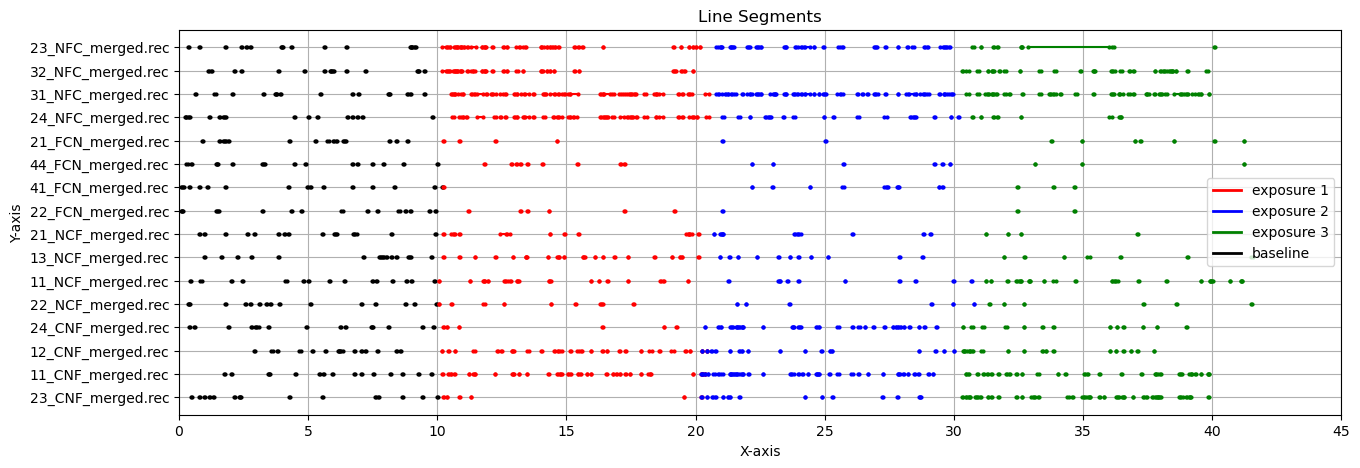

In [88]:
color_dict = {'exposure 1': 'r', 'exposure 2': 'b', 'exposure 3': 'g',
              'baseline' : 'k'}
recording_number = 0
plt.figure(figsize = (15,5))
labels = []
for name, recording in behavior_dicts.items():
    labels.append(name)
    for event, snippets in recording.items():
        if event in color_dict.keys():
            for i in range(len(snippets)):
                y = [recording_number,recording_number]
                x = snippets[i]/1000/60
            # Plot the line segments
                plt.plot(x, y, marker='o', linestyle='-', c= color_dict[event], markersize = 2)
    recording_number += .5
# Optionally, you can add labels, title, etc.
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.yticks(ticks=np.arange(len(labels))/2, labels=labels)
plt.title('Line Segments')
legend_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
plt.legend(handles=legend_labels)
plt.grid(True)
plt.xlim([0,45])
plt.show()

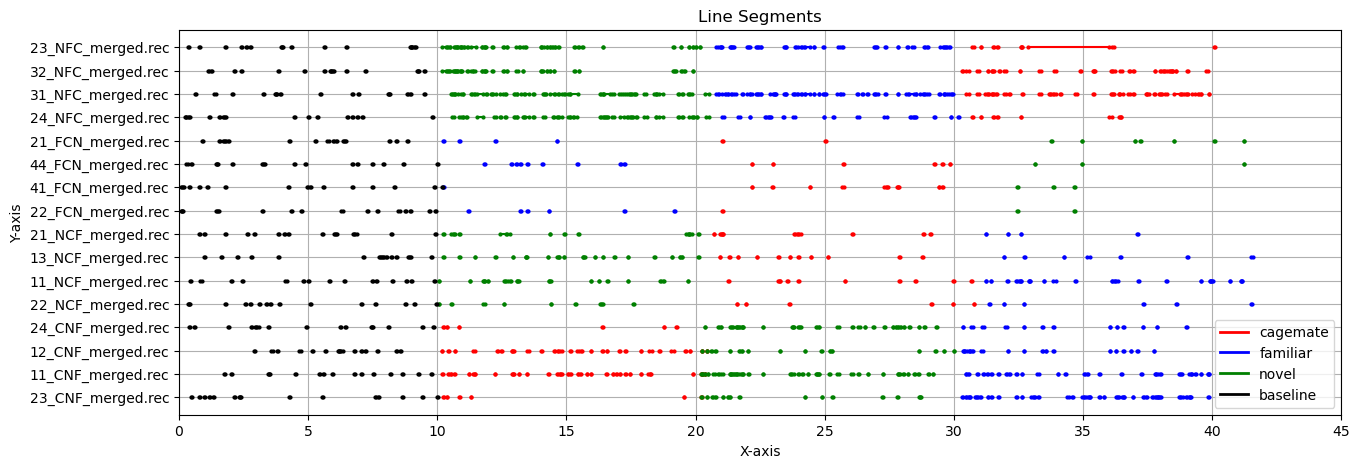

In [89]:
color_dict = {'cagemate': 'r', 'familiar': 'b', 'novel': 'g',
              'baseline' : 'k'}
recording_number = 0
plt.figure(figsize = (15,5))
labels = []
for name, recording in behavior_dicts.items():
    labels.append(name)
    for event, snippets in recording.items():
        if event in color_dict.keys():
            for i in range(len(snippets)):
                y = [recording_number,recording_number]
                x = snippets[i]/1000/60
            # Plot the line segments
                plt.plot(x, y, marker='o', linestyle='-', c= color_dict[event], markersize = 2)
    recording_number += .5
# Optionally, you can add labels, title, etc.
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.yticks(ticks=np.arange(len(labels))/2, labels=labels)
plt.title('Line Segments')
legend_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
plt.legend(handles=legend_labels)
plt.grid(True)
plt.xlim([0,45])
plt.show()

In [90]:
behavior_dicts.keys()

dict_keys(['23_CNF_merged.rec', '11_CNF_merged.rec', '12_CNF_merged.rec', '24_CNF_merged.rec', '22_NCF_merged.rec', '11_NCF_merged.rec', '13_NCF_merged.rec', '21_NCF_merged.rec', '22_FCN_merged.rec', '41_FCN_merged.rec', '44_FCN_merged.rec', '21_FCN_merged.rec', '24_NFC_merged.rec', '31_NFC_merged.rec', '32_NFC_merged.rec', '23_NFC_merged.rec'])

In [91]:
pickle_this(behavior_dicts, r"C:\Users\zhaoz\Desktop\Research\SocialMemory\diff_fam_social_memory_ephys\other_peoples_sutff\Catherine\data_analysis\facial_behavior_dicts.pkl")

In [92]:
# for recording in only_subject_collection.recordings:
#   recording.set_event_dict(behavior_dicts[recording.name])

In [93]:
# only_subject_collection.save_collection(r'pilot2/only_subjects/only_subjects_spike_collection')

In [94]:
# only_subject_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)
# events = ['baseline', 'exposure 1', 'exposure 2', 'exposure 3'
#           ]
# print(pca_trajectories.avg_trajectories_pca(only_subject_collection, event_length = 2.5, pre_window = 3, events=events, d = 3))

In [95]:
# only_subject_collection.analyze(timebin = 50, smoothing_window=500, ignore_freq=0.5)
# print(pca_trajectories.avg_trajectories_pca(only_subject_collection, event_length = 4, pre_window = 4, events = ['cagemate']))

In [96]:
# print(pca_trajectories.avg_trajectories_pca(only_subject_collection, event_length = 4, pre_window = 4, events = ['novel']))

In [97]:
# print(pca_trajectories.avg_trajectories_pca(only_subject_collection, event_length = 4, pre_window = 4, events = ['familiar']))

In [98]:
# print(pca_trajectories.avg_trajectories_pca(only_subject_collection, event_length = 4, pre_window = 4, events = ['baseline']))

In [99]:
# events = ['baseline', 'cagemate', 'novel', 'familiar']
# pca_trajectories.avg_trajectories_pca(only_subject_collection, event_length = 2.5, pre_window = 3, events = events)